<h1 align=center>TP : SVM à noyau pour la prédiction la qualité de vin</h1>

<h2 align=center>CentraleSupélec-OpenClassrooms Certifiyng Training</h2>

<h3 align=center>Jean Martial Tagro </h3>

On va entrainer un algorithme svm.SVC à classifier nos vins (bonne qualité ou pas terrible) en fonction des carateristiques physico-chimiques.
Data source : <a href='https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality'>Archive UCI</a>

In [145]:
# Importations

import pandas as pd
%pylab inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib


### 1. Preparation et exploration

In [146]:
# recuperation des donnees
data_row = pd.read_csv('winequality-white.csv', sep=';')
data_row.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [147]:
data_row.shape

(4898, 12)

In [148]:
# recuperation features/labels
X = data_row.iloc[:,:-1]
y = data_row.iloc[:,-1]

#transformation en probleme de classification
y_class = np.where(y<6, 0, 1) 

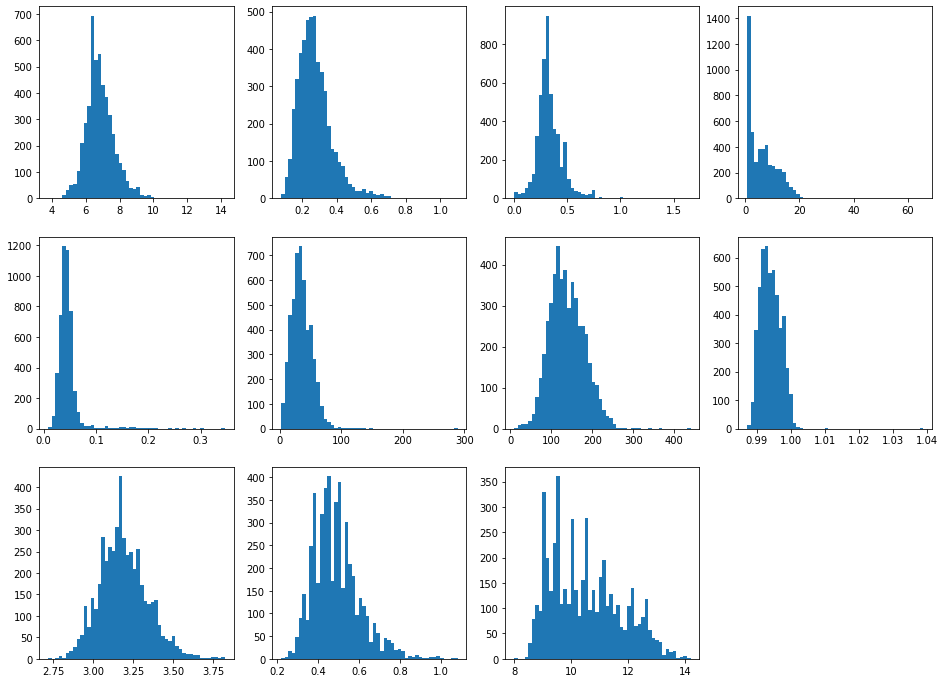

In [149]:
# verification des distributions des features

fig = plt.figure(figsize=(16,12))

for index in range(X.shape[1]):
    
    ax = fig.add_subplot(3, 4, (index+1))
    histogramme = ax.hist(X.values[:, index], bins=50) # ATTENTION à bien preciser 'values'

Les features ne sont pas du tout uniformement distribués. Nous pouvons donc standardiser les variables, c'est-à-dire les centrer (ramener leur moyenne à 0) et les réduire (ramener leur écart-type à 1), afin qu'elles se placent toutes à peu près sur la même échelle.

In [150]:
# creation du standardiseur
scale = StandardScaler()

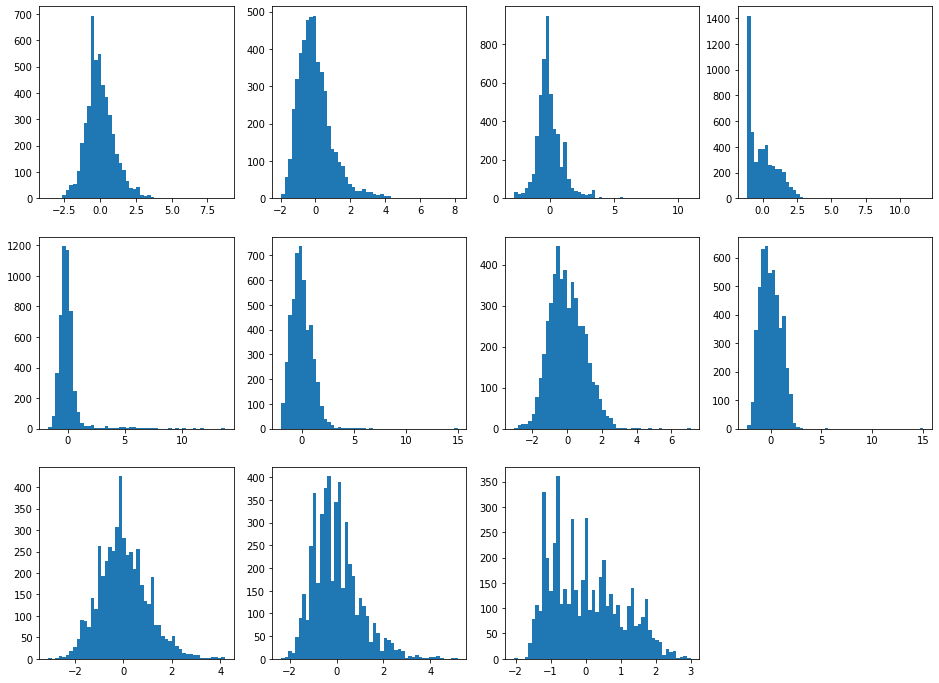

In [151]:
# standardisation
X_std = scale.fit_transform(X)

# Re - verification des distributions des features
fig = plt.figure(figsize=(16,12))

for index in range(X_std.shape[1]):
    
    ax = fig.add_subplot(3, 4, (index+1))
    histogramme = ax.hist(X_std[:, index], bins=50)

In [152]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_std, y_class, test_size=0.3)

---

### 2. Entrainement du SVM à noyau

In [153]:
# Création d'une SVM avec un noyau gaussien de paramètre gamma=0.01

classifier = SVC(C=1.0, kernel='rbf', gamma=0.01) # C: default =1

In [154]:
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

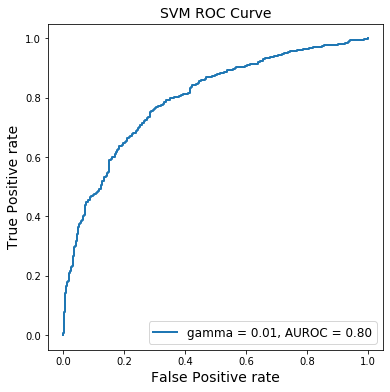

In [155]:
# Observation de sa courbe ROC sur le jeu de test

# predictions
y_pred = classifier.decision_function(X_test)

# recuperation des FPrate, TPrate, thresholds de la confusion matrix
fpr, tpr, thresholds = roc_curve(y_test, y_pred)


# visualisation
fig = plt.figure(figsize=(6,6))

plt.plot(fpr, tpr, '-', lw=2, label='gamma = 0.01, AUROC = %.2f' % roc_auc_score(y_test, y_pred))

plt.xlabel('False Positive rate', fontsize=14)
plt.ylabel('True Positive rate', fontsize=14)
plt.title('SVM ROC Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()

Optimisons ce SVM à noyau via une validation croisée sur C et gamma.

In [156]:
params = {'C':np.logspace(-2,3,6), 'gamma':np.logspace(-2,1,4)}

score = 'roc_auc'

classifier_grid = GridSearchCV(SVC(kernel='rbf'),
                              params,
                              cv=5,
                              scoring=score)

classifier_grid.fit(X_train, y_train)

print("The optimal parameters are {} with a score of {:.2f}".format(classifier_grid.best_params_, classifier_grid.best_score_))

The optimal parameters are {'C': 1.0, 'gamma': 1.0} with a score of 0.85


Nous pouvons maintenant évaluer la performance de notre modèle optimisé sur le jeu de test, par rapport à l'ancien modèle :

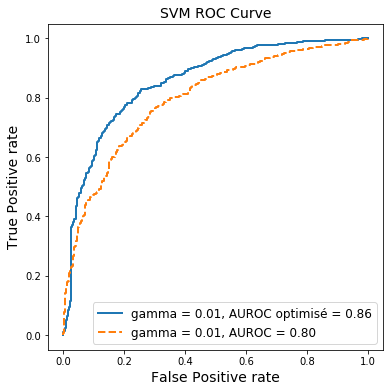

In [157]:
# Observation de sa courbe ROC sur le jeu de test

# predictions
y_pred_grid = classifier_grid.decision_function(X_test)

# recuperation des FPrate, TPrate, thresholds de la confusion matrix du svc grid optimisé
fpr_grid, tpr_grid, thresholds_grid = roc_curve(y_test, y_pred_grid)


# visualisation
fig = plt.figure(figsize=(6,6))

plt.plot(fpr_grid, tpr_grid, '-', lw=2, label='gamma = 0.01, AUROC optimisé = %.2f' % roc_auc_score(y_test, y_pred_grid))
plt.plot(fpr, tpr, '--', lw=2, label='gamma = 0.01, AUROC = %.2f' % roc_auc_score(y_test, y_pred))

plt.xlabel('False Positive rate', fontsize=14)
plt.ylabel('True Positive rate', fontsize=14)
plt.title('SVM ROC Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()

#### Le SVM optimisé via la grid search est bien plus proche du modèle optimal.

___

#### Visualisons l'effet de gamma, controleur de la bande passante du noyau gaussien - en fait inversement proportionnel à celle-ci - avec la matrice Gram

Calculons la matrice de Gram obtenue sur notre jeu d'entraînement quand gamma=0.01 : Et limitons-nous à ses 100 premières lignes et 100 premières colonnes pour en faciliter la visualisation

In [159]:
kmatrix = metrics.pairwise.rbf_kernel(X_train, gamma=0.01)
kmatrix100 = kmatrix[:100, :100]

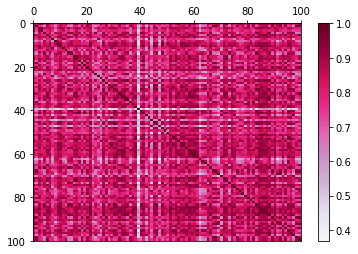

In [162]:
# Visualisation de matrice de Gram

# dessiner la matrice
plt.pcolor(kmatrix100, cmap=matplotlib.cm.PuRd) 

# rajouter la légende
plt.colorbar()

# retourner l'axe des ordonnées
plt.gca().invert_yaxis()

# afficher l'axe des abscisses au dessus
plt.gca().xaxis.tick_top()

# afficher l'image
plt.show()

Nous avons ici des valeurs de noyau comprises entre 0.40 et 1.0, avec une diagonale plus forte mais qui n'écrase pas la matrice.

Essayons par exemple gamma = 50

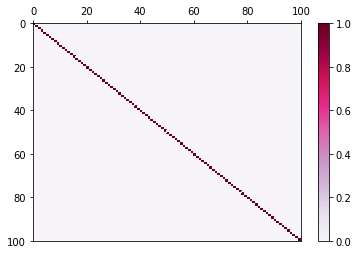

In [164]:
kmatrix_2 = metrics.pairwise.rbf_kernel(X_train, gamma=50)
kmatrix100_2 = kmatrix_2[:100, :100]

# Visualisation de matrice de Gram

# dessiner la matrice
plt.pcolor(kmatrix100_2, cmap=matplotlib.cm.PuRd) 

# rajouter la légende
plt.colorbar()

# retourner l'axe des ordonnées
plt.gca().invert_yaxis()

# afficher l'axe des abscisses au dessus
plt.gca().xaxis.tick_top()

# afficher l'image
plt.show()

Cette matrice est à diagonale dominante. Si l'on entraîne une SVM avec cette valeur de gamma, la courbe ROC est beaucoup moins bonne :

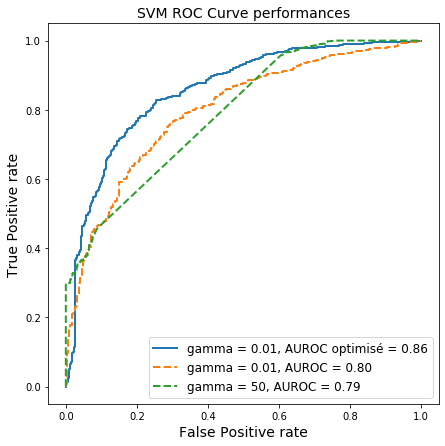

In [169]:
# Observation de courbes ROC 

# construction de la SVC gaussienne avec gamma = 50 et fiter
svc_gamma50 = SVC(C=1.0, kernel='rbf', gamma=50)
svc_gamma50.fit(X_train, y_train)

# predictions
y_pred_gamma50 = svc_gamma50.decision_function(X_test)

# recuperation des FPrate, TPrate, thresholds de la confusion matrix du svc grid optimisé
fpr_g50, tpr_g50, thresholds_g50 = roc_curve(y_test, y_pred_gamma50)


# visualisation
fig = plt.figure(figsize=(7,7))

plt.plot(fpr_grid, tpr_grid, '-', lw=2, label='gamma = 0.01, AUROC optimisé = %.2f' % roc_auc_score(y_test, y_pred_grid))
plt.plot(fpr, tpr, '--', lw=2, label='gamma = 0.01, AUROC = %.2f' % roc_auc_score(y_test, y_pred))
plt.plot(fpr_g50, tpr_g50, '--', lw=2, label='gamma = 50, AUROC = %.2f' % roc_auc_score(y_test, y_pred_gamma50))

plt.xlabel('False Positive rate', fontsize=14)
plt.ylabel('True Positive rate', fontsize=14)
plt.title('SVM ROC Curve performances', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.show()

---